In [ ]:
import librosa
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.fftpack as fft
from scipy.signal import get_window

In [ ]:
PATH = "./sample.wav"

# Load file audionya pakai librosa
audio, sr = librosa.load(PATH)

ipd.Audio(audio, rate=sr)

In [ ]:
print(audio)
print(sr)
print(np.shape(audio))

[ 0.          0.          0.         ...  0.01251221 -0.01358032
 -0.06613159]
22050
(1323000,)


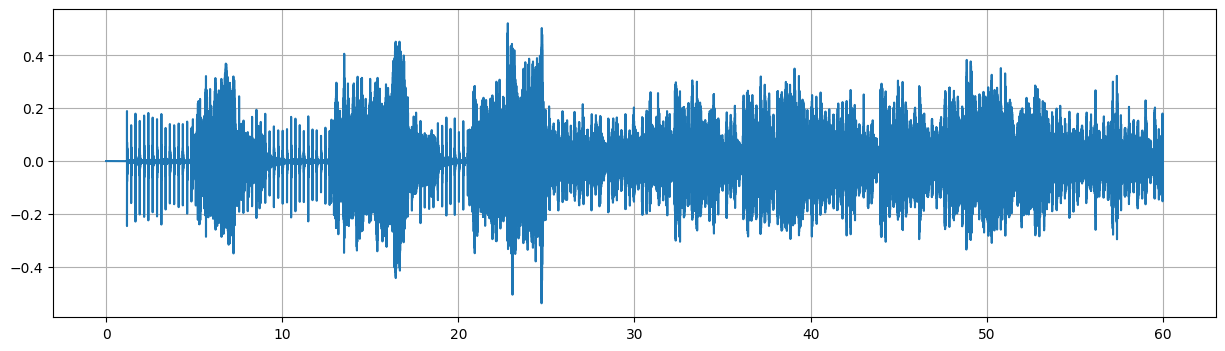

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.grid(True)

In [ ]:
def normalize_audio(audio):
  audio = audio / np.max(np.abs(audio))
  return audio

In [ ]:
audio = normalize_audio(audio)
print(audio)

[ 0.          0.          0.         ...  0.0232545  -0.02523964
 -0.12290851]


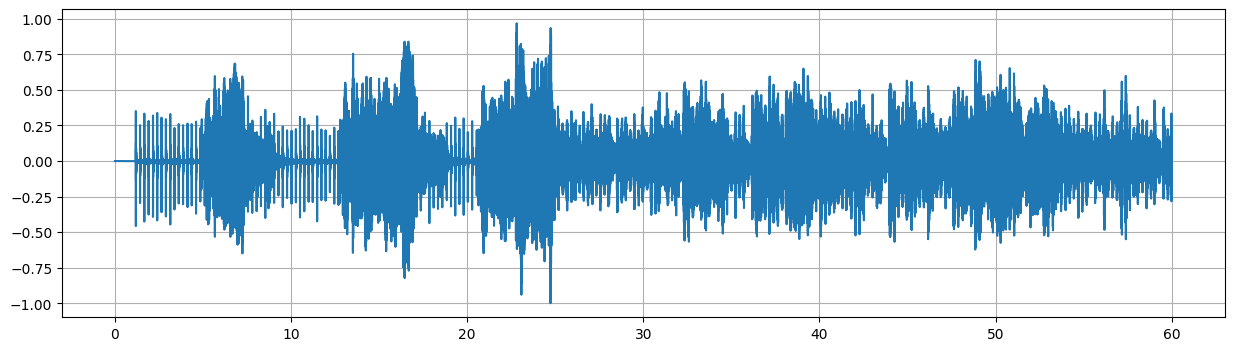

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.grid(True)

In [ ]:
# Framing

def frame_audio(audio, FFT_size, sr, hop_size=10):
  # hop_size dalam ms
  audio = np.pad(audio, int(FFT_size/2), mode='reflect')
  frame_len = np.round(sr * hop_size / 1000).astype(int)
  frame_num = int((len(audio) - FFT_size) / frame_len) + 1
  frames = np.zeros((frame_num, FFT_size))

  for n in range(frame_num):
    frames[n] = audio[n*frame_len:n*frame_len+FFT_size]

  return frames

In [ ]:
FFT_size = 2048
audio_framed = frame_audio(audio, FFT_size, sr=sr)
print(np.shape(audio_framed))
print(audio_framed)

(6014, 2048)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.07469798  0.07628608  0.07776076 ... -0.03584595 -0.01503034
   0.02694118]
 [ 0.03936249  0.03641314  0.0331802  ...  0.07594578  0.0654529
   0.04287902]
 [-0.01446316 -0.01525722 -0.01531394 ... -0.0152005  -0.01310192
  -0.01043616]]


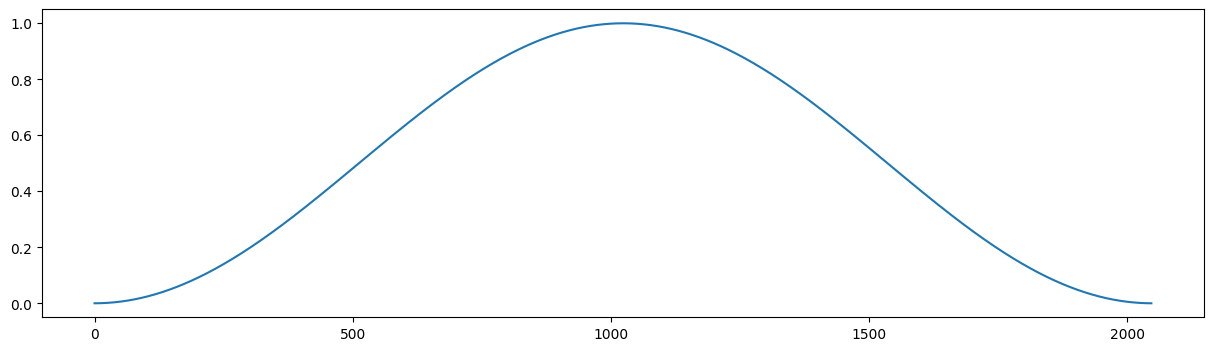

In [ ]:
window = get_window("hann", FFT_size)
plt.figure(figsize=(15,4))
plt.plot(window)

Text(0.5, 1.0, 'After Windowing Frame')

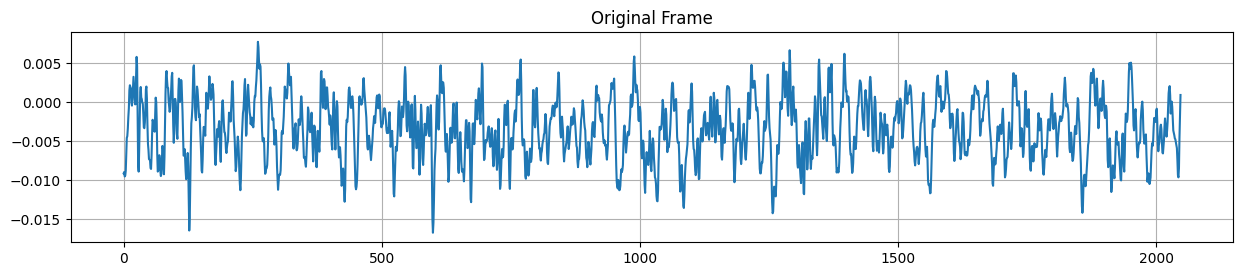

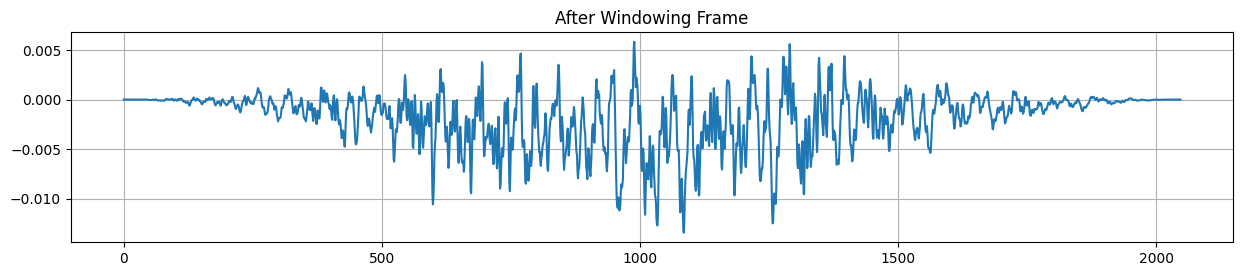

In [ ]:
audio_win = audio_framed * window
idx = 1000

plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[idx])
plt.grid(True)
plt.title("Original Frame")

plt.figure(figsize=(15,6))
plt.subplot(2, 1, 2)
plt.plot(audio_win[idx])
plt.grid(True)
plt.title("After Windowing Frame")

In [ ]:
print(np.shape(audio_win))
audio_winT = np.transpose(audio_win)
print(np.shape(audio_winT))

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype = np.complex64)

for n in range(audio_fft.shape[1]):
  audio_fft[:, n] = fft.fft(audio_winT[:, n])[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

(6014, 2048)
(2048, 6014)


In [ ]:
freq_min = 0
freq_max = sr/2

In [ ]:
# Frequency to Mel-Frequency

def freq_to_mel(freq):
  return 2590 * np.log10(1 + freq / 700)

def mel_to_freq(mel):
  return 700 * (10 ** (mel/2590) - 1)

In [ ]:
mel_filter_num = 6

In [ ]:
def get_filter_point(fmin, fmax, filter_num, FFT_size, sample_rate):
  fmin_mel = freq_to_mel(fmin)
  fmax_mel = freq_to_mel(fmax)

  mels = np.linspace(fmin_mel, fmax_mel, num = filter_num + 2)
  freqs = mel_to_freq(mels)

  return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [ ]:
filter_points, mel_freqs = get_filter_point(freq_min, freq_max, mel_filter_num, FFT_size, sr)
filter_points

array([   0,   32,   80,  152,  260,  421,  663, 1024])

In [ ]:
def get_filters(filter_points, FFT_size):
  filters = np.zeros(((len(filter_points) - 2), int(FFT_size/2 + 1)))

  for n in range(len(filter_points) - 2):
    filters[n, filter_points[n]:filter_points[n+1]] = np.linspace(0, 1, filter_points[n+1] - filter_points[n])
    filters[n, filter_points[n+1]:filter_points[n+2]] = np.linspace(1, 0, filter_points[n+2] - filter_points[n+1])

  return filters

In [ ]:
filters = get_filters(filter_points, FFT_size)

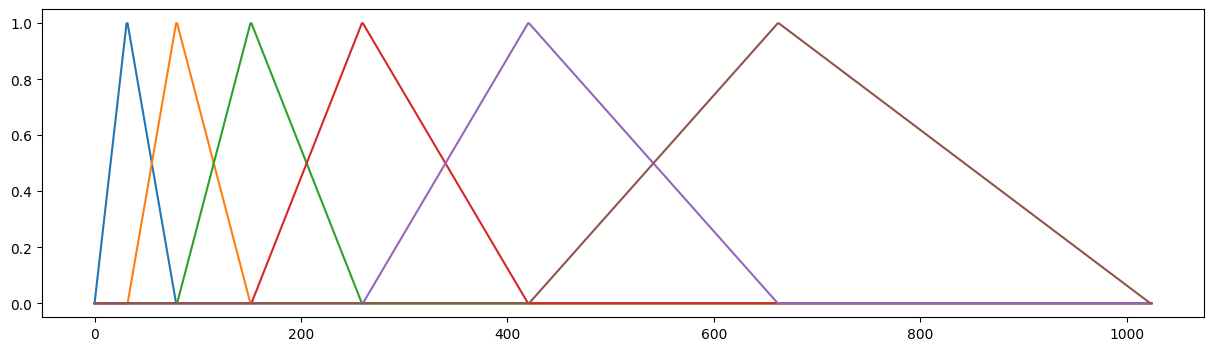

In [ ]:
plt.figure(figsize = (15,4))
for n in range(filters.shape[0]):
  plt.plot(filters[n])

In [ ]:
enorm = 2 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters = filters * enorm[:, np.newaxis]

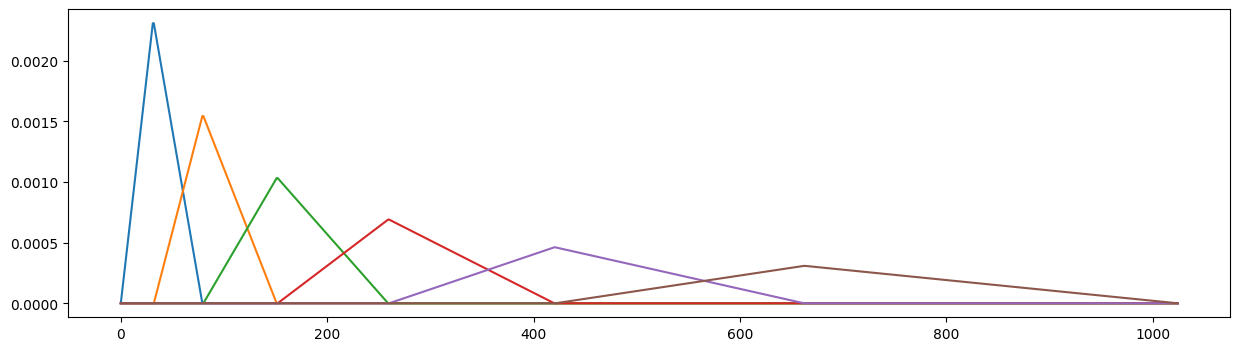

In [ ]:
plt.figure(figsize = (15,4))
for n in range(filters.shape[0]):
  plt.plot(filters[n])

In [ ]:
# Audio Power

audio_power = np.square(np.abs(audio_fft))
np.shape(audio_power)

(6014, 1025)

In [ ]:
# Apply Filter

audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10 * np.log10(audio_filtered)
audio_log.shape

<ipython-input-64-d9b6c24589b9>:4: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10 * np.log10(audio_filtered)


(6, 6014)

In [ ]:
def dct(dct_filter_num, filter_len):
  basis = np.empty((dct_filter_num, filter_len))
  basis[0:1] = 1 / np.sqrt(filter_len)
  samples = np.arange(1, 2*filter_len, 2) * np.pi / (2*filter_len)

  for i in range(1, dct_filter_num):
    basis[i, :] = np.cos(i*samples) * np.sqrt(2 / filter_len)

  return basis

In [ ]:
dct_filter_num = 40
dct_filters = dct(dct_filter_num, mel_filter_num)

# Cepstral Coefficient -> didapatkan dari apply DCT dari hasil Mel Filter
mfcc = np.dot(dct_filters, audio_log)
print(mfcc)

[[        -inf         -inf         -inf ... -15.0879014  -11.83892095
  -10.7462334 ]
 [         nan          nan          nan ...  20.25591733  18.25177818
   16.8955862 ]
 [         nan          nan          nan ...  -5.80990002  -4.49392616
   -3.55232304]
 ...
 [         nan          nan          nan ... -20.25591733 -18.25177818
  -16.8955862 ]
 [         nan          nan          nan ...   5.80990002   4.49392616
    3.55232304]
 [         nan          nan          nan ...  -5.17723633  -5.17851951
   -5.21652062]]
